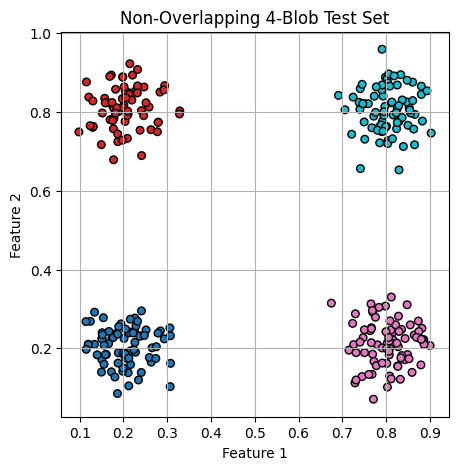

In [24]:
import torch
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# 1) Generate 4 non‑overlapping blobs
centers = [
    [0.2, 0.2],
    [0.2, 0.8],
    [0.8, 0.2],
    [0.8, 0.8],
]
X, y = make_blobs(
    n_samples=1000,
    centers=centers,
    cluster_std=0.05,
    random_state=42
)

# No need to renormalize since centers are already in [0,1]
# 2) Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)

# 3) Convert to torch
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test,  dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test  = torch.tensor(y_test,  dtype=torch.long)

# 4) Scatter‑plot to verify no overlap
plt.figure(figsize=(5,5))
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='tab10', s=30, edgecolor='k')
plt.title("Non‑Overlapping 4‑Blob Test Set")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

Epoch   0 | TrainLoss 2.1974 | ValLoss 2.0679 | ValAcc 0.229
Epoch  20 | TrainLoss 1.7433 | ValLoss 1.7358 | ValAcc 0.229
Epoch  40 | TrainLoss 1.6525 | ValLoss 1.6396 | ValAcc 0.229
Epoch  60 | TrainLoss 1.6155 | ValLoss 1.6060 | ValAcc 0.229
Epoch  80 | TrainLoss 1.5997 | ValLoss 1.5927 | ValAcc 0.229
Epoch 100 | TrainLoss 1.5870 | ValLoss 1.5796 | ValAcc 0.229
Epoch 120 | TrainLoss 1.5665 | ValLoss 1.5568 | ValAcc 0.229
Epoch 140 | TrainLoss 1.5233 | ValLoss 1.5096 | ValAcc 0.229
Epoch 160 | TrainLoss 1.4205 | ValLoss 1.3996 | ValAcc 0.243
Epoch 180 | TrainLoss 1.2533 | ValLoss 1.2259 | ValAcc 0.679
Epoch 200 | TrainLoss 1.1205 | ValLoss 1.0950 | ValAcc 0.750
Epoch 220 | TrainLoss 1.0236 | ValLoss 1.0035 | ValAcc 0.757
Epoch 240 | TrainLoss 0.9573 | ValLoss 0.9406 | ValAcc 0.750
Epoch 260 | TrainLoss 0.9109 | ValLoss 0.8971 | ValAcc 0.750
Epoch 280 | TrainLoss 0.8773 | ValLoss 0.8657 | ValAcc 0.750
Epoch 300 | TrainLoss 0.8523 | ValLoss 0.8425 | ValAcc 0.750
Epoch 320 | TrainLoss 0.

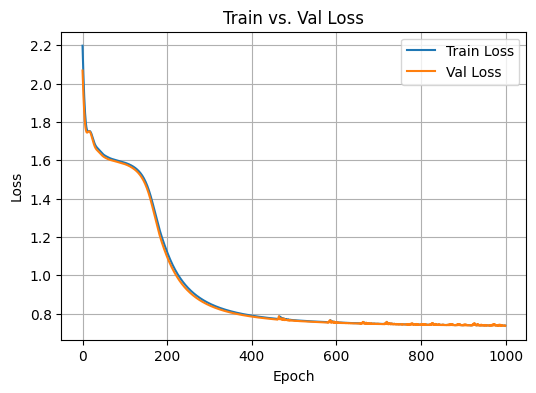

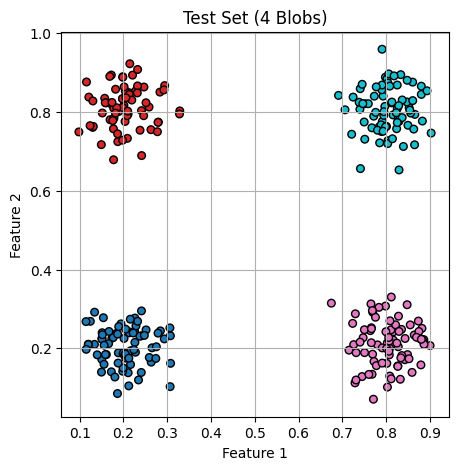

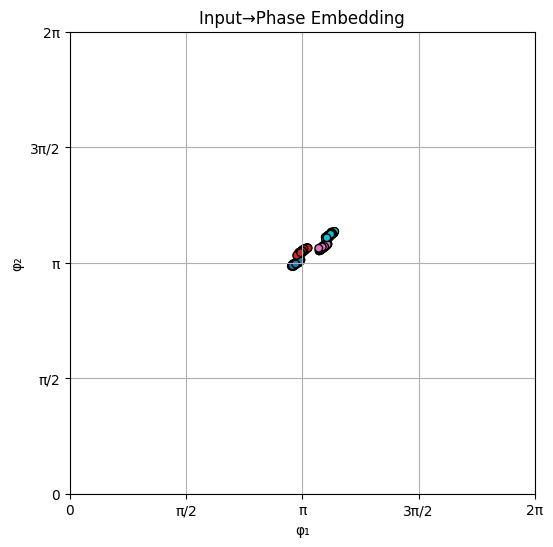

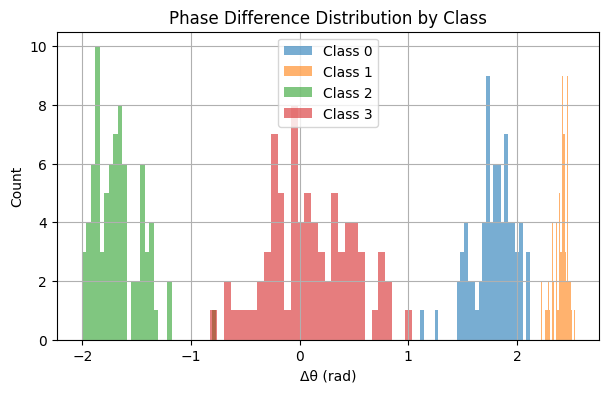

Final Test Accuracy: 93.67%


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# ── 1) DATASET ───────────────────────────────────────────────────────────────
def prepare_data():
    centers = [[0.2,0.2],[0.2,0.8],[0.8,0.2],[0.8,0.8]]
    X, y = make_blobs(n_samples=1000, centers=centers, cluster_std=0.05, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    return (
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.long),
        torch.tensor(X_test,  dtype=torch.float32),
        torch.tensor(y_test,  dtype=torch.long),
    )

# ── 2) MODEL ─────────────────────────────────────────────────────────────────
class TwoOscRegClassifier(nn.Module):
    def __init__(self, dt=0.05):
        super().__init__()
        # 2D input → 2 phases (before sigmoid)
        self.input2phase = nn.Linear(2, 2)
        # asymmetric couplings
        self.K12 = nn.Parameter(torch.tensor(1.0))
        self.K21 = nn.Parameter(torch.tensor(1.0))
        self.dt  = dt
        # target class angles
        self.class_angles = torch.tensor([np.pi/2, np.pi, -np.pi/2, 0.0])

    def forward(self, x, steps=40):
        # embed input → [0,2π]
        phi0 = torch.sigmoid(self.input2phase(x)) * 2 * np.pi
        θ1, θ2 = phi0[:,0], phi0[:,1]

        # simulate Kuramoto coupling
        for _ in range(steps):
            d1 = self.K12 * torch.sin(θ2 - θ1)
            d2 = self.K21 * torch.sin(θ1 - θ2)
            θ1 = θ1 + self.dt * d1
            θ2 = θ2 + self.dt * d2

        # phase difference Δθ ∈ [–π, π]
        Δ = (θ2 - θ1 + np.pi) % (2*np.pi) - np.pi
        # classification logits
        logits = torch.cos(Δ.unsqueeze(1) - self.class_angles.to(x.device).unsqueeze(0))
        return logits, Δ, phi0

# ── 3) TRAIN & VALIDATE ─────────────────────────────────────────────────────
def train_validate(model, X_tr, y_tr, X_val, y_val, epochs=200, reg_weight=1.0):
    opt = optim.Adam(model.parameters(), lr=0.01)
    crit = nn.CrossEntropyLoss()

    train_losses = []
    val_losses   = []

    for ep in range(epochs):
        model.train()
        logits_tr, Δ_tr, phi_tr = model(X_tr)
        loss_ce  = crit(logits_tr, y_tr)
        # regularizer: keep initial phase difference small
        loss_reg = ((phi_tr[:,0] - phi_tr[:,1])**2).mean()
        loss_tr  = loss_ce + reg_weight * loss_reg

        opt.zero_grad()
        loss_tr.backward()
        opt.step()
        train_losses.append(loss_tr.item())

        model.eval()
        with torch.no_grad():
            logits_val, _, phi_val = model(X_val)
            loss_ce_val  = crit(logits_val, y_val)
            loss_reg_val = ((phi_val[:,0] - phi_val[:,1])**2).mean()
            loss_v       = loss_ce_val + reg_weight * loss_reg_val
            val_losses.append(loss_v.item())

        if ep % 20 == 0:
            acc_val = logits_val.argmax(1).eq(y_val).float().mean().item()
            print(f"Epoch {ep:3d} | TrainLoss {loss_tr.item():.4f} | ValLoss {loss_v:.4f} | ValAcc {acc_val:.3f}")

    return train_losses, val_losses

# ── 4) PLOT LOSS CURVES ──────────────────────────────────────────────────────
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses,   label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.title('Train vs. Val Loss')
    plt.legend(); plt.grid(True); plt.show()

# ── 5) PLOT TEST SCATTER ────────────────────────────────────────────────────
def plot_test_scatter(X, y):
    plt.figure(figsize=(5,5))
    plt.scatter(X[:,0], X[:,1], c=y, cmap='tab10', s=30, edgecolor='k')
    plt.title("Test Set (4 Blobs)")
    plt.xlabel("Feature 1"); plt.ylabel("Feature 2")
    plt.grid(True); plt.show()

# ── 6) VISUALIZE INPUT→PHASE EMBEDDING ──────────────────────────────────────
def plot_phase_embedding(model, X, y):
    model.eval()
    with torch.no_grad():
        raw = model.input2phase(X)
        phi = torch.sigmoid(raw) * 2 * np.pi
    phi_np = phi.cpu().numpy(); y_np = y.cpu().numpy()

    plt.figure(figsize=(6,6))
    plt.scatter(phi_np[:,0], phi_np[:,1],
                c=y_np, cmap='tab10', s=30, edgecolor='k')
    plt.title("Input→Phase Embedding")
    plt.xlabel("φ₁"); plt.ylabel("φ₂")
    ticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
    labels= ['0','π/2','π','3π/2','2π']
    plt.xticks(ticks, labels); plt.yticks(ticks, labels)
    plt.grid(True); plt.show()

# ── 7) PLOT Δθ HISTOGRAM ─────────────────────────────────────────────────────
def plot_delta_hist(model, X, y):
    model.eval()
    with torch.no_grad():
        _, Δ, _ = model(X)
        Δ_np = Δ.cpu().numpy(); y_np = y.cpu().numpy()

    plt.figure(figsize=(7,4))
    for c in range(4):
        plt.hist(Δ_np[y_np==c], bins=30, alpha=0.6, label=f"Class {c}")
    plt.title("Phase Difference Distribution by Class")
    plt.xlabel("Δθ (rad)"); plt.ylabel("Count")
    plt.legend(); plt.grid(True); plt.show()

# ── 8) MAIN ─────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    # prepare data
    X_tr, y_tr, X_te, y_te = prepare_data()
    # split off validation set
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_tr.numpy(), y_tr.numpy(), test_size=0.2, random_state=1
    )
    X_tr = torch.tensor(X_tr, dtype=torch.float32)
    y_tr = torch.tensor(y_tr, dtype=torch.long)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.long)

    # instantiate and train
    model = TwoOscRegClassifier(dt=0.01)
    train_losses, val_losses = train_validate(
        model, X_tr, y_tr, X_val, y_val,
        epochs=1000, reg_weight=1.0
    )

    # plots
    plot_losses(train_losses, val_losses)
    plot_test_scatter(X_te, y_te)
    plot_phase_embedding(model, X_te, y_te)
    plot_delta_hist(model, X_te, y_te)

    # final test accuracy
    with torch.no_grad():
        logits_test, _, _ = model(X_te)
        acc_test = logits_test.argmax(1).eq(y_te).float().mean().item()
    print(f"Final Test Accuracy: {acc_test*100:.2f}%")


In [32]:
model.K12, model.K21

(Parameter containing:
 tensor(-4.4657, requires_grad=True),
 Parameter containing:
 tensor(-4.4657, requires_grad=True))

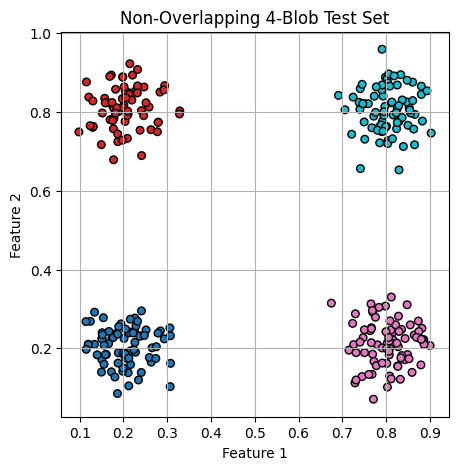